In [7]:
f = open('../movie/ratings.dat', 'r')
data = f.readlines()
f = open('../movie/movies.dat', 'r', encoding='ISO-8859-1')
movies = f.readlines()
movie_names = [_.split('::')[1] for _ in movies]
movie_ids = [_.split('::')[0] for _ in movies]
movie_dict = dict(zip(movie_ids, movie_names))
movie_categories_multi = [_.split('::')[2].rstrip("\n").split('|') for _ in movies]
movie_categories = [[_[0]] for _ in movie_categories_multi]
movie_category_dict = dict(zip(movie_ids, movie_categories))
id_mapping = dict(zip(movie_ids, range(len(movie_ids))))

In [8]:
cnt = 0
interaction_dicts = dict()
for line in data:
    user_id, movie_id, rating, timestamp = line.split('::')
    if float(rating) <= 3.0: continue
    if user_id not in interaction_dicts:
        interaction_dicts[user_id] = {
            'movie_id': [],
            'rating': [],
            'timestamp': [],
            'movie_title': [],
        }
    cnt += 1
    interaction_dicts[user_id]['movie_id'].append(movie_id)
    interaction_dicts[user_id]['rating'].append(int(float(rating) > 3.0))
    interaction_dicts[user_id]['timestamp'].append(timestamp)
    interaction_dicts[user_id]['movie_title'].append(movie_dict[movie_id])
cnt


5885448

In [9]:
from collections import Counter

def acc_value(rating_list):
    return sum(rating_list)

# def div_list(id_list):
#     previous_category = set()
#     div_list = []
#     for i in id_list:
#         i_category = set(movie_category_dict[i])
#         union = previous_category.union(i_category)
#         intersection = previous_category.intersection(i_category)
#         jaccard_similarity = len(intersection) / len(union)
#         div_list.append((1 - jaccard_similarity)/len(id_list))
#         previous_category = union
#     return div_list

# def div_value(id_list):
#     return sum(div_list(id_list))

def get_cate_list(id_list, movie_category_dict):
    cate_list = []
    for id_ in id_list:
        cate_list += movie_category_dict[id_]
    element_counts = Counter(cate_list)
    sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
    cate_list = [cate for cate, count in sorted_counts]
    return cate_list
    

In [10]:
from tqdm import tqdm
sequential_interaction_list = []
seq_len = 10
for user_id in tqdm(interaction_dicts):
    temp = zip(interaction_dicts[user_id]['movie_id'], interaction_dicts[user_id]['rating'], interaction_dicts[user_id]['timestamp'], interaction_dicts[user_id]['movie_title'])
    temp = sorted(temp, key=lambda x: int(x[2]))
    result = zip(*temp)
    interaction_dicts[user_id]['movie_id'], interaction_dicts[user_id]['rating'], interaction_dicts[user_id]['timestamp'], interaction_dicts[user_id]['movie_title'] = [list(_) for _ in result]
    
    if len(interaction_dicts[user_id]['movie_id'])-seq_len+1 <= seq_len: continue
    for i in range(seq_len, len(interaction_dicts[user_id]['movie_id'])-seq_len+1):
        sequential_interaction_list.append(
            {"uid": user_id, 
             "history_title": interaction_dicts[user_id]['movie_title'][i - seq_len: i],
             "history_id": interaction_dicts[user_id]['movie_id'][i-seq_len:i], 
             "history_rating": interaction_dicts[user_id]['rating'][i-seq_len:i], 
             "future_title": interaction_dicts[user_id]['movie_title'][i : i + seq_len], 
             "future_id": interaction_dicts[user_id]['movie_id'][i : i + seq_len], 
             "future_rating": interaction_dicts[user_id]['rating'][i : i + seq_len], 
             "acc_label": acc_value(interaction_dicts[user_id]['rating'][i-seq_len:i]),
             "history_cates": get_cate_list(interaction_dicts[user_id]['movie_id'][i - seq_len: i], movie_category_dict), 
             "future_cates": get_cate_list(interaction_dicts[user_id]['movie_id'][i : i + seq_len], movie_category_dict), 
             "time": interaction_dicts[user_id]['timestamp'][i].strip('\n')}
        )
print(len(sequential_interaction_list))

100%|██████████| 69816/69816 [03:29<00:00, 333.49it/s] 

4650273


In [44]:
sequential_interaction_list[0] 

{'uid': '1',
 'history_title': ['Aladdin (1992)',
  'Dumb & Dumber (1994)',
  'Stargate (1994)',
  'Star Trek: Generations (1994)',
  'Outbreak (1995)',
  'Net, The (1995)',
  'Forrest Gump (1994)',
  'Jurassic Park (1993)',
  'Lion King, The (1994)',
  'Terminator 2: Judgment Day (1991)'],
 'history_id': ['588',
  '231',
  '316',
  '329',
  '292',
  '185',
  '356',
  '480',
  '364',
  '589'],
 'history_rating': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'future_title': ['Speed (1994)',
  'Beverly Hills Cop III (1994)',
  'Sleepless in Seattle (1993)',
  'Home Alone (1990)',
  'Flintstones, The (1994)',
  'Naked Gun 33 1/3: The Final Insult (1994)',
  'Hot Shots! Part Deux (1993)',
  'Robin Hood: Men in Tights (1993)',
  'Snow White and the Seven Dwarfs (1937)',
  'Jungle Book, The (1994)'],
 'future_id': ['377',
  '420',
  '539',
  '586',
  '355',
  '370',
  '466',
  '520',
  '594',
  '362'],
 'future_rating': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'acc_label': 10,
 'history_cates': ['Action', 'Adven

In [12]:
history_cate_len_list = [len(_['history_cates']) for _ in sequential_interaction_list]
element_counts = Counter(history_cate_len_list)
sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
elements, counts = zip(*sorted_counts)
sorted_counts

[(4, 1458561),
 (5, 1353777),
 (3, 760842),
 (6, 594059),
 (2, 257105),
 (7, 130423),
 (1, 80515),
 (8, 14271),
 (9, 714),
 (10, 6)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


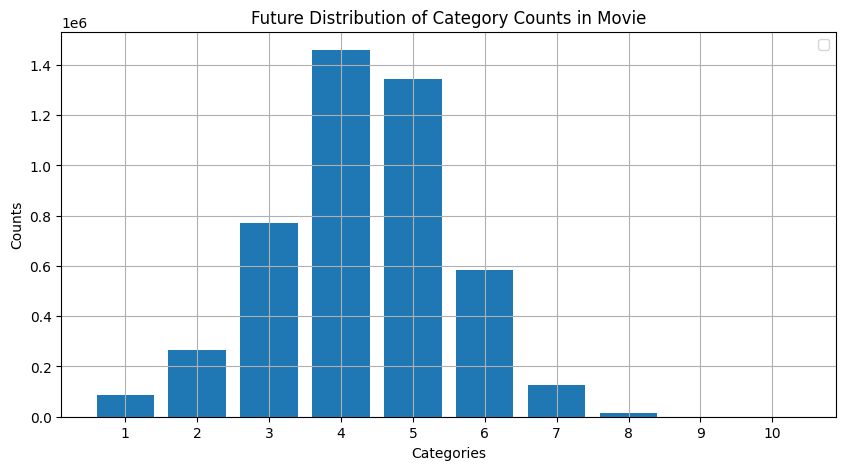

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


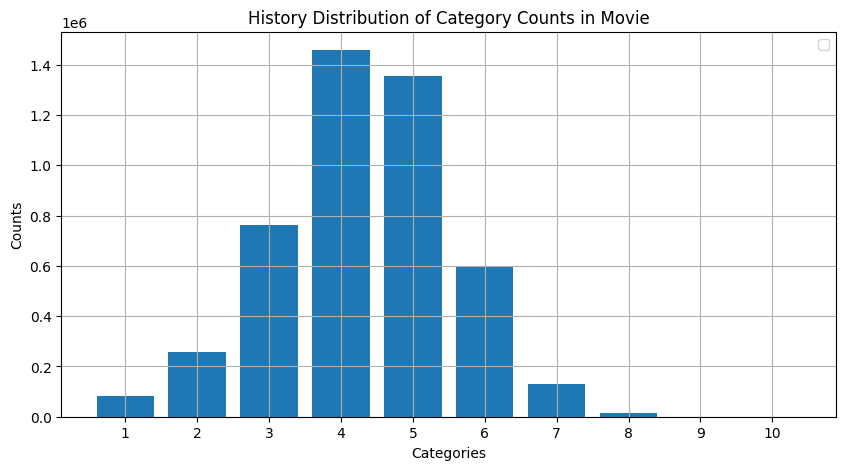

In [11]:
import matplotlib.pyplot as plt

future_cate_len_list = [len(_['future_cates']) for _ in sequential_interaction_list]
history_cate_len_list = [len(_['history_cates']) for _ in sequential_interaction_list]

def plot_count_cate(cate_len_list, name=''):
    # 使用 Counter 统计每种元素出现的次数
    element_counts = Counter(cate_len_list)

    # 对次数进行排序
    sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
    
    # 分别获取元素和对应的次数
    elements, counts = zip(*sorted_counts)

    # 绘制条形图
    plt.figure(figsize=(10, 5))
    # 使用 tick_labels 参数来指定 x 轴上的标签
    bars = plt.bar(elements, counts, tick_label=elements)
    
    # 设置 x 轴的标签
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title(f'{name} Distribution of Category Counts in Movie')
    plt.grid(True)
    
    # 显示 x 轴上的标签
    plt.xticks(elements)
    
    # 显示图例
    plt.legend()

    # 显示图表
    plt.show()
    
plot_count_cate(future_cate_len_list, 'Future')
plot_count_cate(history_cate_len_list, 'History')

In [46]:
sorted_list = sorted(sequential_interaction_list, key=lambda x: int(x["time"]))
saved_list = [[_["uid"], _["history_title"], _["history_id"], _["future_title"], _["future_id"], _["acc_label"], _["history_cates"], _["future_cates"], _["time"]] for _ in sorted_list]
import csv
with open('./train.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'history_title', 'history_id', 'future_title', 'future_id',  'acc_value', 'history_cates', 'future_cates', 'timestamp'])
    writer.writerows(saved_list[:int(len(saved_list)*0.8)])
with open('./valid.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'history_title', 'history_id', 'future_title', 'future_id',  'acc_value', 'history_cates', 'future_cates',  'timestamp'])
    writer.writerows(saved_list[int(len(saved_list)*0.8):int(len(saved_list)*0.9)])
with open('./test.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'history_title', 'history_id', 'future_title', 'future_id',  'acc_value', 'history_cates', 'future_cates',  'timestamp'])
    writer.writerows(saved_list[int(len(saved_list)*0.9):])

In [ ]:
# 统计genre频率 统计每个genre中电影概率
cate_list = [] # GP 从剩下genre里依概率替换一个
cate_movie_map = [] # IP 从相同genre中依概率替换电影

In [2]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BIGRec(input_path, output_path, sample=False, sample_num=5000):
    data = pd.read_csv(input_path)
    if sample:
        data = data.sample(n=sample_num, random_state=42).reset_index(drop=True)
        #data.to_csv(output_path[:-5] + ".csv", index=False)
    json_list = []
    for index, row in tqdm(data.iterrows()):
        row['history_title'] = eval(row['history_title'])
        L = len(row['history_title'])
        history = "The user has watched the following movies before:"
        for i in range(L):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\""
            else:
                history += ", \"" + row['history_title'][i] + "\""
                
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        json_list.append({
            "instruction": "Given a list of movies the user likes, please recommend 10 new movies that the user likes to the user and end each movie with the sign \"|\".",
            "input": f"{history}\n ",
            "output": future,
        })        
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [3]:
csv_to_json_BIGRec('./train.csv', './train_BIGRec_1000.json', sample=True, sample_num=1000)
csv_to_json_BIGRec('./valid.csv', './valid_BIGRec_1000.json', sample=True, sample_num=1000)
csv_to_json_BIGRec('./test.csv', './test_BIGRec_1000.json', sample=True, sample_num=1000)

1000it [00:00, 4236.39it/s]
1000it [00:00, 3638.93it/s]
1000it [00:00, 4754.01it/s]


In [4]:
def csv_to_json_RAW(input_path, output_path, sample=False, sample_num=5000):
    data = pd.read_csv(input_path)
    if sample:
        data = data.sample(n=sample_num, random_state=42).reset_index(drop=True)
        #data.to_csv(output_path[:-5] + ".csv", index=False)
    json_list = []
    for index, row in tqdm(data.iterrows()):
        row['history_title'] = eval(row['history_title'])
        L = len(row['history_title'])
        history = "The user has watched the following movies before:"
        for i in range(L):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\""
            else:
                history += ", \"" + row['history_title'][i] + "\""
                
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        json_list.append({
            "instruction": "Given a list of movies the user likes in the Amazon store, please recommend 10 new movies that the user likes to the user. End each video game with the sign \"|\" and output the names only, without explanations or numbers. The output format should be like \'\"Movie1\"| \"Movie2\"| ...| \"Movie10\"| \'.",
            "input": f"{history}\n ",
            "output": future,
        })        
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [5]:
csv_to_json_RAW('./test.csv', './test_RAW_1000.json', sample=True, sample_num=1000)

1000it [00:00, 4172.68it/s]


In [66]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BERT(input_path, output_path_GL, output_path_GP, output_path_GP_genre, output_path_GF, output_path_IP, sample=False, n=5000):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        # data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_dict = {
        'GL': [],
        'GP': [],
        'GF': [],
        'GP_genre': [],
        'IP': []
    }
    
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        history_cate = [movie_category_dict[hi][0] for hi in history_id]
        
        history_tuples = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, history_cate)]
        
        history_tuples_GL_input = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, '?' * len(history_cate))]
        history_tuples_GL_output = history_tuples

        history = ', '.join(history_tuples)

        future_title = eval(row['future_title'])
        future_id = eval(row['future_id'])
        future_cate = [movie_category_dict[fi][0] for fi in future_id]
        
        future_tuples_GL = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title), '_' * len(future_cate))]
                
        future_tuples_GP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title), '?' * len(future_cate))]
        future_tuples_GP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('_' * len(future_title), future_cate)]
            
        future_tuples_IP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('?' * len(future_title), future_cate)]
        future_tuples_IP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip(future_title, future_cate)]

        
        trail_GL_input = ', '.join(history_tuples_GL_input + future_tuples_GL)
        trail_GL_output = ', '.join(history_tuples_GL_output + future_tuples_GL)
        
        trail_GP_input = ', '.join(history_tuples + future_tuples_GP_input)
        trail_GP_output = ', '.join(history_tuples + future_tuples_GP_output)
        
        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        GF_genres = '[' + ', '.join(eval(row['future_cates'])) + ']' # set of future_cate
        
        json_dict['GL'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\". The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GL_input}",
            "output": trail_GL_output,
        })
        json_dict['GP'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\". The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GP_input}",
            "output": trail_GP_output,
        })
        json_dict['GP_genre'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\" with exactly {len(set(future_cate))} types. The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GP_input}",
            "output": trail_GP_output,
        })
        json_dict['GF'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the genre placeholders represented by \"?\" with the following genres: {GF_genres}. The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_GP_input}",
            "output": trail_GP_output,
        })
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the movie placeholders represented by \"?\". The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })
 
    with open(output_path_GL, 'w') as f:
        json.dump(json_dict['GL'], f, indent=4)
        
    with open(output_path_GP, 'w') as f:
        json.dump(json_dict['GP'], f, indent=4)
    
    with open(output_path_GP_genre, 'w') as f:
        json.dump(json_dict['GP_genre'], f, indent=4)
    
    with open(output_path_GF, 'w') as f:
        json.dump(json_dict['GF'], f, indent=4)
        
    with open(output_path_IP, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)


In [67]:
csv_to_json_BERT('./train.csv', './train_1000_BERT_GL.json', './train_1000_BERT_GP.json', './train_1000_BERT_GP_genre.json', './train_1000_BERT_GF.json', './train_1000_BERT_IP.json', sample=True, n=1000)
csv_to_json_BERT('./valid.csv', './valid_1000_BERT_GL.json', './valid_1000_BERT_GP.json', './valid_1000_BERT_GP_genre.json', './valid_1000_BERT_GF.json', './valid_1000_BERT_IP.json', sample=True, n=1000)
csv_to_json_BERT('./test.csv', './test_1000_BERT_GL.json', './test_1000_BERT_GP.json', './test_1000_BERT_GP_genre.json', './test_1000_BERT_GF.json', './test_1000_BERT_IP.json', sample=True, n=1000)
# csv_to_json_BERT('./train.csv', './train_5000_BERT_GL.json', './train_5000_BERT_GP.json', './train_5000_BERT_GP_genre.json', './train_5000_BERT_GF.json', './train_5000_BERT_IP.json', sample=True, n=5000)
# csv_to_json_BERT('./valid.csv', './valid_5000_BERT_GL.json', './valid_5000_BERT_GP.json', './valid_5000_BERT_GP_genre.json', './valid_5000_BERT_GF.json', './valid_5000_BERT_IP.json', sample=True, n=5000)
# csv_to_json_BERT('./test.csv', './test_5000_BERT_GL.json', './test_5000_BERT_GP.json', './test_5000_BERT_GP_genre.json', './test_5000_BERT_GF.json', './test_5000_BERT_IP.json', sample=True, n=5000)



5000it [00:01, 4162.03it/s]
5000it [00:01, 4381.25it/s]
5000it [00:01, 4500.47it/s]


In [64]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BERT_IP_shuffle(input_path, output_path_IP, sample=False, n=5000):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        # data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_dict = {
        'IP': []
    }
    
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        history_cate = [movie_category_dict[hi][0] for hi in history_id]
        
        history_tuples = ['\"' + ht + '\"' + "\'" + hc + "\'" for ht, hc in zip(history_title, history_cate)]

        history = ', '.join(history_tuples)

        future_title = eval(row['future_title'])
        future_id = eval(row['future_id'])
        future_cate = [movie_category_dict[fi][0] for fi in future_id]
        
        random.seed(1)
        indices = list(range(len(future_title)))
        random.shuffle(indices)
        shuffled_title = [future_title[i] for i in indices]
        shuffled_cate = [future_cate[i] for i in indices]
        
        future_tuples_IP_input = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip('?' * len(shuffled_title), shuffled_cate)]
        future_tuples_IP_output = ['\"' + ft + '\"' + "\'" + fc + "\'" for ft, fc in zip(shuffled_title, shuffled_cate)]

        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        GF_genres = '[' + ', '.join(eval(row['future_cates'])) + ']' # set of future_cate
        
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\", followed by its genre in single quotes ''. Your task is to fill in the movie placeholders represented by \"?\". The \"_\" represents placeholder tokens that you should not consider. The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })
        
    with open(output_path_IP, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)


In [65]:
csv_to_json_BERT_IP_shuffle('./train.csv', './train_1000_BERT_IP_shuffle.json', sample=True, n=1000)
csv_to_json_BERT_IP_shuffle('./valid.csv', './valid_1000_BERT_IP_shuffle.json', sample=True, n=1000)
csv_to_json_BERT_IP_shuffle('./test.csv',  './test_1000_BERT_IP_shuffle.json', sample=True, n=1000)


1000it [00:00, 4713.41it/s]
1000it [00:00, 4828.18it/s]
1000it [00:00, 4841.22it/s]


In [12]:
import json
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
def csv_to_json_BERT_IP_pureitem(input_path, output_path_IP, sample=False, n=5000):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        # data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_dict = {
        'IP': []
    }
    
    for index, row in tqdm(data.iterrows()):
        history_title = eval(row['history_title'])
        history_id = eval(row['history_id'])
        
        history_tuples = ['\"' + ht + '\"' for ht in (history_title)]

        history = ', '.join(history_tuples)

        future_title = eval(row['future_title'])
        future_id = eval(row['future_id'])
        
        future_tuples_IP_input = ['\"' + ft + '\"'  for ft in '?' * len(future_title)]
        future_tuples_IP_output = ['\"' + ft + '\"' for ft in future_title]

        trail_IP_input = ', '.join(history_tuples + future_tuples_IP_input)
        trail_IP_output = ', '.join(history_tuples + future_tuples_IP_output)
        
        GF_genres = '[' + ', '.join(eval(row['future_cates'])) + ']' # set of future_cate
        
        json_dict['IP'].append({
            "instruction": f"Below is a user's interaction trail of movies he likes. Each movie is in double quotes \"\". Your task is to fill in the movie placeholders represented by \"?\". The output should maintain the same format as the input.",
            "input": f"{trail_IP_input}",
            "output": trail_IP_output,
        })
        
    with open(output_path_IP, 'w') as f:
        json.dump(json_dict['IP'], f, indent=4)


In [13]:
csv_to_json_BERT_IP_pureitem('./train.csv', './train_1000_BERT_IP_pi.json', sample=True, n=1000)
csv_to_json_BERT_IP_pureitem('./valid.csv', './valid_1000_BERT_IP_pi.json', sample=True, n=1000)
csv_to_json_BERT_IP_pureitem('./test.csv',  './test_1000_BERT_IP_pi.json', sample=True, n=1000)


1000it [00:00, 2538.59it/s]
1000it [00:00, 3282.10it/s]
1000it [00:00, 4937.75it/s]


In [2]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_step1_purecate2(input_path, output_path, sample=False, n=5000, div_prompt=False, is_test=False):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following genres of movies before:"
        for i in range(len(row['history_title'])):
            cate_list = movie_category_dict[eval(row['history_id'])[i]]
            if i == 0:
                history += cate_list[0]
            else:
                history += ", " + cate_list[0]
  
        
        row['future_cates'] = eval(row['future_cates'])
        future = ""
        for i in range(len(row['future_cates'])):
            if i == 0:
                future += row['future_cates'][i]
            else:
                future += ", " + row['future_cates'][i]

        json_list.append({
            "instruction": f"Based on the user's past preferences, predict and recommend the {len(row['future_cates'])} genres that the user is most likely to enjoy in the future. Consider the user's pattern of watching different genres and suggest a diverse yet personalized selection. Output only the genres in a simple list format, separated by commas, without any additional context or explanation. The output format should be 'Genre1, Genre2, ...Genre{len(row['future_cates'])}'.",
            "input": f"{history}.\n",
            "output": future,
        })    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)


In [3]:
csv_to_json_step1_purecate2('./train.csv', './train_1000_purecate2.json', sample=True, n=1000)
csv_to_json_step1_purecate2('./valid.csv', './valid_1000_purecate2.json', sample=True, n=1000)
csv_to_json_step1_purecate2('./test.csv', './test_1000_purecate2.json', sample=True, n=1000)


In [5]:
import json
import pandas as pd
import random
import numpy as np
def GP_puregenre(input_path, output_path, sample=False, n=5000, div_prompt=False, is_test=False):
    # almost similar to csv_to_json_step1, but only input genres
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following genres of movies before:"
        for i in range(len(row['history_title'])):
            cate_list = movie_category_dict[eval(row['history_id'])[i]]
            if i == 0:
                history += cate_list[0]
            else:
                history += ", " + cate_list[0]
  
        
        row['future_cates'] = eval(row['future_cates'])
        future = ""
        for i in range(len(row['future_cates'])):
            if i == 0:
                future += row['future_cates'][i]
            else:
                future += ", " + row['future_cates'][i]

        json_list.append({
            "instruction": f"Given a list of genres of movies the user has watched before, please provide the {len(row['future_cates'])} most likely genres in the future recommendation list. Output the genres only, without movie names, explanations or numbers. The output format is \"Genre1, Genre2, ..., Genre{len(row['future_cates'])}\".",
            "input": f"{history}.\n",
            "output": future,
        })    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)


In [6]:
GP_puregenre('./train.csv', './train_1000_pg.json', sample=True, n=1000)
GP_puregenre('./valid.csv', './valid_1000_pg.json', sample=True, n=1000)
GP_puregenre('./test.csv', './test_1000_pg.json', sample=True, n=1000)


In [23]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_step1(input_path, output_path, sample=False, n=5000, is_num=True):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        row['future_cates'] = eval(row['future_cates'])
        future = ""
        for i in range(len(row['future_cates'])):
            if i == 0:
                future += row['future_cates'][i]
            else:
                future += ", " + row['future_cates'][i]
        if is_num:
            json_list.append({
                "instruction": f"Given a list of movies and their corresponding genres the user has watched before, please provide the {len(row['future_cates'])} most likely genres in the future recommendation list. Output the genres only, without movie names, explanations or numbers. The output format is \"Genre1, Genre2, ..., Genre{len(row['future_cates'])}\".",
                "input": f"{history}.\n",
                "output": future,
            })    
        else:
            json_list.append({
                "instruction": f"Given a list of movies and their corresponding genres the user has watched before, please provide the most likely genres in the future recommendation list of 10 movies. Output the genres only, without movie names, explanations or numbers. The output format is \"Genre1, Genre2, ...\".",
                "input": f"{history}.\n",
                "output": future,
            })
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)


In [5]:
# csv_to_json_step1('./train.csv', './train_1000.json', sample=True, n=1000)
# csv_to_json_step1('./valid.csv', './valid_1000.json', sample=True, n=1000)
# csv_to_json_step1('./test.csv', './test_1000.json', sample=True, n=1000)
csv_to_json_step1('./train.csv', './train_1000_nonum.json', sample=True, n=1000, is_num=False)
csv_to_json_step1('./valid.csv', './valid_1000_nonum.json', sample=True, n=1000, is_num=False)
csv_to_json_step1('./test.csv', './test_1000_nonum.json', sample=True, n=1000, is_num=False)


In [24]:
def csv_to_json_noCoT(input_path, output_path, sample=False, n=5000, genre_control=0):
    # csv_to_json_step2
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        #data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
                        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        json_sample = {
            "instruction": f"Given a list of movies and their corresponding genres the user has watched beforethe future recommendation list, please recommend 10 new movies that the user likes to the user with {genre_num} genres. The genres of the suggested movies should correspond precisely to the genres you have made up. End each movie with the sign \"|\" and output the movies only, without genres, explanations or numbers. \
The output format should be like \"Movie1| Movie2| ... Movie10| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [28]:
csv_to_json_noCoT('./train.csv', './train_noCoT_1000.json', sample=True, n=1000)
csv_to_json_noCoT('./valid.csv', './valid_noCoT_1000.json', sample=True, n=1000)
csv_to_json_noCoT('./test.csv', './test_noCoT_1000.json', sample=True, n=1000)
csv_to_json_noCoT('./test.csv', './test_noCoT_1000_2.json', sample=True, n=1000, genre_control=2)
csv_to_json_noCoT('./test.csv', './test_noCoT_1000_5.json', sample=True, n=1000, genre_control=5)
csv_to_json_noCoT('./test.csv', './test_noCoT_1000_8.json', sample=True, n=1000, genre_control=8)

In [25]:
def csv_to_json_CoT(input_path, output_path, sample=False, n=5000, genre_control=0):
    # csv_to_json_step2
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        #data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
                        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        json_sample = {
            "instruction": f"Given a list of movies and their corresponding genres the user has watched before, please think of the {genre_num} most likely genres in the future recommendation list. \
According to the history and future genres, please recommend 10 new movies that the user likes to the user. The genres of the suggested movies should correspond precisely to the genres you have made up. End each movie with the sign \"|\" and output the movies only, without genres, explanations or numbers. \
The output format should be like \"Movie1| Movie2| ... Movie10| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [26]:
csv_to_json_CoT('./train.csv', './trainCoT_1000.json', sample=True, n=1000)
csv_to_json_CoT('./valid.csv', './validCoT_1000.json', sample=True, n=1000)
csv_to_json_CoT('./test.csv', './testCoT_1000.json', sample=True, n=1000)

In [27]:
csv_to_json_CoT('./test.csv', './testCoT_1000_2.json', sample=True, n=1000, genre_control=2)
csv_to_json_CoT('./test.csv', './testCoT_1000_5.json', sample=True, n=1000, genre_control=5)
csv_to_json_CoT('./test.csv', './testCoT_1000_8.json', sample=True, n=1000, genre_control=8)

In [22]:
def generate_movie_item(movie_names, movie_categories, output_path, batch_size=10):
    json_list = []
    for i in range(0, len(movie_names), batch_size):
        batch_movie = movie_names[i:i + batch_size]
        batch_cate = movie_categories[i:i + batch_size]
        
        history = "The user has watched the following movies before:"
        for i in range(len(batch_movie)):
            if i == 0:
                history += "\"" + batch_movie[i] + "\""
            else:
                history += ", \"" + batch_movie[i] + "\""
        
        future = ""
        for i in range(len(batch_cate)):
            for j in range(len(batch_cate[i])):
                if j == 0:
                    future += batch_cate[i][j] 
                else:
                    future += ', ' + batch_cate[i][j] 
            future += '| '
                
        json_sample = {
            "instruction": f"Given a list of movies, please predict their corresponding genres. \
Seperate the genres of a movie with \",\". End each movie's genres with the sign \"|\" and output the genres only. \
The output format should be like \"Genre_a, Genre_b| Genre_c| ...Genre_y, Genre_z| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)  
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)
        

In [23]:
generate_movie_item(movie_names, movie_categories, './train_item_cate_10.json', batch_size=10)
generate_movie_item(movie_names, movie_categories, './train_item_cate_5.json', batch_size=5)
generate_movie_item(movie_names, movie_categories, './train_item_cate_1.json', batch_size=1)
generate_movie_item(movie_names, movie_categories, './train_item_cate_20.json', batch_size=20)
generate_movie_item(movie_names, movie_categories, './train_item_cate_50.json', batch_size=50)



In [54]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_GP2(input_path, output_path, sample=False, n=5000, div_prompt=False, is_test=False):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        row['future_cates'] = eval(row['future_cates'])
        row['future_id'] = eval(row['future_id'])
        future = ""
        for i in range(len(row['future_id'])):
            future += movie_category_dict[row['future_id'][i]][0] # only one cate
            future += "| "

        json_list.append({
            "instruction": f"Given a list of movies and their corresponding genres the user has watched before, please provide the genres for the next 10 movies the user likes. Ensure the genres collectively span exactly {len(row['future_cates'])} different categories. End each genre with the sign \"|\" and output the genres only. The output format is \"Genre1| Genre2| ...| Genre10| \".",
            "input": f"{history}.\n",
            "output": future,
        })    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)


In [55]:
csv_to_json_GP2('./train.csv', './train1.1_1000.json', sample=True, n=1000)
csv_to_json_GP2('./valid.csv', './valid1.1_1000.json', sample=True, n=1000)
csv_to_json_GP2('./test.csv', './test1.1_1000.json', sample=True, n=1000)

In [56]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_step2_GP2(input_path, output_path, sample=False, n=5000, genre_control=0):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
                        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"| "
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
            
        json_sample = {
            "instruction": f"Given a list of movies and their corresponding genres the user has watched before, please think of the genres for the next 10 movies the user likes. Ensure the genres collectively span exactly {genre_num} different categories. \
According to the history and future genres, please recommend 10 new movies that the user likes to the user. The genres of the suggested movies should correspond precisely to the genres you have made up. End each movie with the sign \"|\" and output the movies only, without genres, explanations or numbers. \
The output format should be like \"Movie1| Movie2| ... Movie10| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [57]:
csv_to_json_step2_GP2('./train.csv', './train2.1_1000.json', sample=True, n=1000)
csv_to_json_step2_GP2('./valid.csv', './valid2.1_1000.json', sample=True, n=1000)
csv_to_json_step2_GP2('./test.csv', './test2.1_1000.json', sample=True, n=1000)

In [58]:
csv_to_json_step2_GP2('./test.csv', './test2.1_1000_5.json', sample=True, n=1000, genre_control=5)
csv_to_json_step2_GP2('./test.csv', './test2.1_1000_10.json', sample=True, n=1000, genre_control=10)
csv_to_json_step2_GP2('./test.csv', './test2.1_1000_15.json', sample=True, n=1000, genre_control=15)

In [64]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_step202(input_path, output_path, sample=False, n=5000, genre_control=0):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        future_cates = eval(row['future_cates'])
        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"(" + movie_category_dict[eval(row['future_id'])[i]][0] + ")| "
                
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
            
        json_sample = {
            "instruction": f"Given a list of movies and their corresponding genres the user has watched before, \
please recommend 10 new movies that the user likes to the user whose genres are among {future_cates}. End each movie with its genre and the sign \"|\". \
The output format should be like \"Movie1(Genre1)| Movie2(Genre2)| ... Movie10(Genre10)| \".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [83]:
csv_to_json_step202('./train.csv', './train2.2_1000.json', sample=True, n=1000)
csv_to_json_step202('./valid.csv', './valid2.2_1000.json', sample=True, n=1000)
csv_to_json_step202('./test.csv', './test2.2_1000.json', sample=True, n=1000)

In [80]:
import json
import pandas as pd
import random
import numpy as np
def csv_to_json_step203(input_path, output_path, sample=False, n=5000, genre_control=0):
    
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        future_cates = eval(row['future_cates'])
        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"(" + movie_category_dict[eval(row['future_id'])[i]][0] + ")| "
                
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
            
        json_sample = {
            "instruction": f"Given a list of movies and their corresponding genres the user has watched before, \
please recommend 10 new movies that the user likes to the user. The genres of movies must be include {future_cates}. Do not miss any of these genres. Do not recommend movies of other genres. Please End each movie with its genre and the sign \"|\".",
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [82]:
csv_to_json_step203('./train.csv', './train2.3_1000.json', sample=True, n=1000)
csv_to_json_step203('./valid.csv', './valid2.3_1000.json', sample=True, n=1000)
csv_to_json_step203('./test.csv', './test2.3_1000.json', sample=True, n=1000)

In [28]:
import json
import pandas as pd
import random
import numpy as np
def GP104(input_path, output_path, sample=False, n=5000, div_prompt=False, is_test=False):
    # multi instruction, specify task
    random.seed(0)
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        # data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        row['future_cates'] = eval(row['future_cates'])
        future = ""
        for i in range(len(row['future_cates'])):
            if i == 0:
                future += row['future_cates'][i]
            else:
                future += ", " + row['future_cates'][i]
        
        GP_sentences = [
            f"Based on the user's movie history, suggest the top {len(row['future_cates'])} genres for future recommendations. List only the genres in the format 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}'.",
            f"Analyze the user's past movie genres and predict {len(row['future_cates'])} potential favorites for future suggestions. Output should include genres in the sequence 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', excluding any other details.",
            f"Identify the {len(row['future_cates'])} genres that the user is most likely to enjoy in upcoming recommendations. Present these genres in a simple list as 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', without additional context.",
            f"From the user's previous movie genre preferences, deduce and list the {len(row['future_cates'])} genres anticipated for future recommendation. The output must be in the style 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', free of movie names or extraneous information.",
            f"Using the user's watched movie genres, forecast {len(row['future_cates'])} genres suitable for future recommendation lists. Display the genres in the format 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', omitting movie names, explanations, or numerical data.",
            f"After reviewing the genres of movies the user has seen, recommend {len(row['future_cates'])} genres for future viewing. The response should be a concise list: 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', with no movie titles, explanations, or numerical indicators.",
            f"From a list of genres associated with movies the user has watched, select and enumerate the {len(row['future_cates'])} most probable genres for future recommendations. The output should strictly follow the pattern 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', excluding any movie names, explanations, or counts.",
            f"Based on the user's movie genre watchlist, generate a list of {len(row['future_cates'])} genres anticipated for future recommendations. The output should strictly be the genres in the order 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', without any accompanying details.",
            f"Considering the genres of movies the user has viewed, propose {len(row['future_cates'])} genres for future recommendation. The output format should be a straightforward list: 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', devoid of movie names, explanations, or numerical annotations.",
            f"Given the user's history with movie genres, determine {len(row['future_cates'])} genres for future recommendation. The output should be a list of genres in the format 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', without including movie titles, explanations, or numerical values.",
            f"After examining the genres of movies watched by the user, compile a list of {len(row['future_cates'])} genres for potential future recommendations. The output should be formatted as 'Genre1, Genre2, ..., Genre{len(row['future_cates'])}', excluding any movie names, explanations, or numerical information."
        ]
        json_list.append({
            "instruction": "This is a Genre Predicting Task. " + random.choice(GP_sentences),
            "input": f"{history}.\n",
            "output": future,
        })    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)


In [29]:
GP104('./train.csv', './train1.4_1000.json', sample=True, n=1000)
GP104('./valid.csv', './valid1.4_1000.json', sample=True, n=1000)
GP104('./test.csv', './test1.4_1000.json', sample=True, n=1000)

In [38]:
import json
import pandas as pd
import random
import numpy as np
def GL104(movie_names, movie_categories, output_path, batch_size=10):
    random.seed(0)
    json_list = []
    for i in range(0, len(movie_names), batch_size):
        batch_movie = movie_names[i:i + batch_size]
        batch_cate = movie_categories[i:i + batch_size]
        
        history = "The user has watched the following movies before:"
        for i in range(len(batch_movie)):
            if i == 0:
                history += "\"" + batch_movie[i] + "\""
            else:
                history += ", \"" + batch_movie[i] + "\""
        
        future = ""
        for i in range(len(batch_cate)):
            for j in range(len(batch_cate[i])):
                if j == 0:
                    future += batch_cate[i][j] 
                else:
                    future += ', ' + batch_cate[i][j] 
            future += '| '
            GL_sentences = [
                "Based on the list of movies provided, predict the single genre for each. Use '|' to separate each movie's genre, with the format 'Genre_1| Genre_2| ...| Genre_n|'.",
                "Analyze the given movies and identify their unique genres. End each movie's genre with a '|', listing them as 'Genre_1| Genre_2| ...| Genre_n|' without additional details.",
                "For the set of movies, determine and list the single corresponding genre for each. Follow the pattern 'Genre_1| Genre_2| ...| Genre_n|', with each genre concluded by a '|'.",
                "Given the array of movies, assign the single genre to each. Concatenate the genres and conclude each with a '|', in the format 'Genre_1| Genre_2| ...| Genre_n|'.",
                "Using the provided list of movies, deduce the single genre for each. Display them sequentially as 'Genre_1| Genre_2| ...| Genre_n|', with a '|' marking the end of each genre entry.",
                "From the collection of movies, ascertain the single genre that matches each one. Output the genres in the format 'Genre_1| Genre_2| ...| Genre_n|', each ended with a '|'.",
                "For each movie in the list, predict its single genre and append a '|' after it. The output should be structured as 'Genre_1| Genre_2| ...| Genre_n|', containing only the genres.",
                "Based on the movies presented, forecast the single genre and conclude each with a '|'. The output should follow the style 'Genre_1| Genre_2| ...| Genre_n|', focusing solely on the genres.",
                "Given the selection of movies, identify their single genres and separate each with a '|'. The output format should be 'Genre_1| Genre_2| ...| Genre_n|', excluding any extraneous text.",
                "For the supplied movies, provide their single genres and use a '|' to delineate each. Present the genres in the order 'Genre_1| Genre_2| ...| Genre_n|', with no additional commentary or formatting."
            ]
        json_sample = {
            "instruction": "This is a Genre Learning Task. " + random.choice(GL_sentences),
            "input": f"{history}.\n",
            "output": future,
        }
        json_list.append(json_sample)  
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)
        

In [39]:
GL104(movie_names, movie_categories, './train1.4_item_cate_10.json', batch_size=10)
GL104(movie_names, movie_categories, './train1.4_item_cate_5.json', batch_size=5)
GL104(movie_names, movie_categories, './train1.4_item_cate_1.json', batch_size=1)
GL104(movie_names, movie_categories, './train1.4_item_cate_20.json', batch_size=20)
GL104(movie_names, movie_categories, './train1.4_item_cate_15.json', batch_size=50)

In [36]:
import json
import pandas as pd
import random
import numpy as np
def IP204(input_path, output_path, sample=False, n=5000, genre_control=0):
    random.seed(0)
    data = pd.read_csv(input_path)
    
    if sample:
        if data.shape[0] < n: print("error! No enough samples!")
        data = data.sample(n=n, random_state=42).reset_index(drop=True)
        data.to_csv(output_path[:-5] + ".csv", index=False)
        
    json_list = []
    
    for index, row in data.iterrows():
        row['history_title'] = eval(row['history_title'])
        history = "The user has watched the following movies with their corresponding genres in \"()\" before:"
        for i in range(len(row['history_title'])):
            if i == 0:
                history += "\"" + row['history_title'][i] + "\" "
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
            else:
                history += ", \"" + row['history_title'][i] + "\""
                cate_list = movie_category_dict[eval(row['history_id'])[i]]
                for j in range(len(cate_list)):
                    if j == 0:  
                        history += "(" + cate_list[j]
                    else:
                         history += ", " + cate_list[j]
                    if j == len(cate_list)-1:
                        history += ")"
        
        future_cates = eval(row['future_cates'])
        
        row['future_title'] = eval(row['future_title'])
        future = ""
        for i in range(len(row['future_title'])):
                future += "\"" + row['future_title'][i] + "\"(" + movie_category_dict[eval(row['future_id'])[i]][0] + ")| "
                
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        
        if genre_control:
            genre_num = genre_control
        else:        
            genre_num = len(eval(row['future_cates']))
        
        rec_len = 10
        IP_sentences = [
            f"Based on the user's past movie preferences, suggest {rec_len} new movies encompassing the genres specified in {future_cates}. Each movie recommendation should end with its genre followed by a '|'.",
            f"Curating a list of {rec_len} new movies for the user, ensure that each selection aligns with the genres outlined in {future_cates}. Conclude each movie entry with its genre and a '|'.",
            f"For the user's enjoyment, propose {rec_len} new movies that include all the genres from {future_cates}. Finish the description of each movie with its genre and a '|'.",
            f"Identify and recommend {rec_len} new movies that strictly adhere to the genres listed in {future_cates}. Append a '|' after the genre of each recommended movie.",
            f"Select {rec_len} new movies that the user is likely to enjoy, with genres matching those in {future_cates}. End each movie's genre listing with a '|'.",
            f"Offer a personalized selection of {rec_len} new movies that include the genres {future_cates}. Designate a '|' after the genre of each movie in the list.",
            f"Craft a list of {rec_len} new movie recommendations that incorporate the genres {future_cates}. Each movie's genre should be suffixed with a '|'.",
            f"Recommend {rec_len} new movies to the user, ensuring that the genres match those in {future_cates}. Signify the end of each movie's genre information with a '|'.",
            f"Suggest {rec_len} new films to the user, making sure that the genres included are those from {future_cates}. Finish the genre specification for each movie with a '|'.",
            f"Create a compilation of {rec_len} new movies tailored to the user's taste, with all genres included in {future_cates}. End the genre for each movie recommendation with a '|'.",
            f"Assemble a list of {rec_len} new movie suggestions that reflect the genres {future_cates}. Conclude each movie's genre with a '|' to indicate the end of its entry."
        ]
        
        json_sample = {
            "instruction": "This is a Item Predicting Task. " + random.choice(IP_sentences),
            "input": f"{history}.\n",
            "output": future,
            "future_cates": future_cates
        }
        json_list.append(json_sample)    
 
    with open(output_path, 'w') as f:
        json.dump(json_list, f, indent=4)

In [37]:
IP204('./train.csv', './train2.4_1000.json', sample=True, n=1000)
IP204('./valid.csv', './valid2.4_1000.json', sample=True, n=1000)
IP204('./test.csv', './test2.4_1000.json', sample=True, n=1000)

In [5]:
# for sasrec
import pandas as pd
train_1000 = pd.read_csv('./train_1000.csv')
seq = []
len_seq = []
next_ = []
for index, row in train_1000.iterrows():
    trail = eval(row['history_id']) + eval(row['future_id'])
    trail = [id_mapping[ori_id] for ori_id in trail]
    assert len(trail)==20
    for i in range(20-10-1):
        seq.append(trail[i:10+i])
        len_seq.append(10)
        next_.append(trail[10+i])
train_data_SAS = pd.DataFrame({
    'seq': seq,
    'len_seq': len_seq,
    'next': next_
})
train_data_SAS.to_pickle('./train_data.df')
train_data_SAS

seq  len_seq  next
0     [1263, 360, 3029, 148, 2631, 5406, 1877, 5253,...       10   582
1     [360, 3029, 148, 2631, 5406, 1877, 5253, 5889,...       10  1557
2     [3029, 148, 2631, 5406, 1877, 5253, 5889, 584,...       10   476
3     [148, 2631, 5406, 1877, 5253, 5889, 584, 582, ...       10  4792
4     [2631, 5406, 1877, 5253, 5889, 584, 582, 1557,...       10  1645
...                                                 ...      ...   ...
8995  [293, 5891, 3004, 3101, 1427, 5892, 5874, 4640...       10  5571
8996  [5891, 3004, 3101, 1427, 5892, 5874, 4640, 131...       10  1252
8997  [3004, 3101, 1427, 5892, 5874, 4640, 1317, 558...       10   442
8998  [3101, 1427, 5892, 5874, 4640, 1317, 5581, 557...       10  4160
8999  [1427, 5892, 5874, 4640, 1317, 5581, 5571, 125...       10    21

[9000 rows x 3 columns]

In [7]:
valid_1000 = pd.read_csv('./valid_1000.csv')
seq = []
len_seq = []
next_ = []
for index, row in valid_1000.iterrows():
    trail = eval(row['history_id']) + eval(row['future_id'])
    trail = [id_mapping[ori_id] for ori_id in trail]
    assert len(trail)==20
    for i in range(20-10-1):
        seq.append(trail[i:10+i])
        len_seq.append(10)
        next_.append(trail[10+i])
valid_1000_SAS = pd.DataFrame({
    'seq': seq,
    'len_seq': len_seq,
    'next': next_
})
valid_1000_SAS.to_pickle('./val_sessions.df')
valid_1000_SAS


seq  len_seq  next
0     [2609, 1910, 1937, 227, 2883, 1204, 1164, 1980...       10  2557
1     [1910, 1937, 227, 2883, 1204, 1164, 1980, 2661...       10  3023
2     [1937, 227, 2883, 1204, 1164, 1980, 2661, 2343...       10  2830
3     [227, 2883, 1204, 1164, 1980, 2661, 2343, 2557...       10  2060
4     [2883, 1204, 1164, 1980, 2661, 2343, 2557, 302...       10  2040
...                                                 ...      ...   ...
8995  [9262, 1187, 2515, 1937, 3337, 2706, 5803, 965...       10  8740
8996  [1187, 2515, 1937, 3337, 2706, 5803, 9655, 775...       10  9707
8997  [2515, 1937, 3337, 2706, 5803, 9655, 7752, 970...       10   896
8998  [1937, 3337, 2706, 5803, 9655, 7752, 9706, 874...       10  6695
8999  [3337, 2706, 5803, 9655, 7752, 9706, 8740, 970...       10   913

[9000 rows x 3 columns]

In [15]:
valid_1000 = pd.read_csv('./valid_1000.csv')
seq = []
len_seq = []
next_ = []
for index, row in valid_1000.iterrows():
    seq.append([id_mapping[ori_id] for ori_id in eval(row['history_id'])])
    next_.append([id_mapping[ori_id] for ori_id in eval(row['future_id'])])
    len_seq.append(10)
valid_1000_SAS = pd.DataFrame({
    'seq': seq,
    'len_seq': len_seq,
    'next': next_
})
valid_1000_SAS.to_pickle('./valid_data.df')
valid_1000_SAS

seq  len_seq  \
0    [2609, 1910, 1937, 227, 2883, 1204, 1164, 1980...       10   
1    [909, 888, 911, 1858, 892, 1855, 1207, 1868, 1...       10   
2    [206, 5253, 1471, 2831, 1175, 2487, 9918, 1927...       10   
3    [1304, 2077, 5581, 527, 305, 5129, 4187, 7942,...       10   
4    [2218, 3168, 2614, 5363, 8266, 297, 1374, 9457...       10   
..                                                 ...      ...   
995  [2949, 2003, 2859, 9520, 1292, 1000, 293, 352,...       10   
996  [293, 4899, 1195, 7039, 2245, 8776, 4879, 1187...       10   
997  [5895, 9015, 4879, 6762, 3904, 4787, 352, 148,...       10   
998  [1528, 9157, 2678, 1242, 2487, 360, 721, 591, ...       10   
999  [6751, 1067, 8268, 8427, 9262, 1187, 2515, 193...       10   

                                                  next  
0    [2557, 3023, 2830, 2060, 2040, 300, 5581, 3089...  
1    [1235, 1860, 1238, 1265, 1068, 9281, 1876, 125...  
2    [2615, 583, 5322, 3856, 2031, 9204, 1172, 4784...  
3    [3480, 1923, 1266, 1153, 587, 7257, 3819, 7953...  
4    [2572, 220, 7026, 1672, 1079, 2900, 3993, 2237...  
..                                                 ...  
995  [376, 583, 584, 148, 108, 257, 586, 453, 1184,...  
996  [4143, 9706, 1224, 7042, 7142, 895, 4784, 9604...  
997  [1171, 2773, 721, 581, 1528, 2544, 1263, 537, ...  
998  [535, 353, 38, 139, 1113, 2631, 16, 2312, 4899...  
999  [5803, 9655, 7752, 9706, 8740, 9707, 896, 6695...  

[1000 rows x 3 columns]

In [16]:
test_1000 = pd.read_csv('./test_1000.csv')
seq = []
len_seq = []
next_ = []
for index, row in test_1000.iterrows():
    seq.append([id_mapping[ori_id] for ori_id in eval(row['history_id'])])
    next_.append([id_mapping[ori_id] for ori_id in eval(row['future_id'])])
    len_seq.append(10)
test_1000_SAS = pd.DataFrame({
    'seq': seq,
    'len_seq': len_seq,
    'next': next_
})
test_1000_SAS.to_pickle('./test_data.df')
test_1000_SAS


seq  len_seq  \
0    [2510, 1672, 1596, 10124, 1217, 10031, 9476, 9...       10   
1    [1171, 640, 2773, 2487, 1173, 46, 1242, 163, 3...       10   
2    [3186, 2833, 1231, 1229, 10038, 2418, 4885, 48...       10   
3    [1008, 503, 1750, 587, 2256, 1922, 9074, 1188,...       10   
4    [1180, 2076, 6662, 951, 8766, 9801, 2264, 3587...       10   
..                                                 ...      ...   
995  [349, 1916, 2556, 1349, 887, 1339, 2269, 516, ...       10   
996  [6281, 6145, 4984, 7825, 1997, 8396, 3947, 527...       10   
997  [1040, 3015, 3825, 1929, 2336, 3381, 903, 220,...       10   
998  [4802, 5349, 1557, 9681, 345, 9, 1172, 9076, 3...       10   
999  [360, 9095, 315, 9961, 4213, 589, 3942, 1242, ...       10   

                                                  next  
0    [8159, 1800, 10092, 10071, 10144, 10005, 8426,...  
1    [1944, 591, 2677, 721, 496, 1528, 1661, 9, 325...  
2    [315, 2874, 5889, 333, 8781, 1052, 1169, 4879,...  
3    [5123, 9376, 9561, 4170, 1588, 1429, 5434, 98,...  
4    [843, 10070, 1067, 1195, 1176, 1187, 1169, 359...  
..                                                 ...  
995  [1870, 1917, 2900, 4802, 312, 5322, 3439, 1913...  
996  [6254, 1349, 1515, 4703, 5279, 6620, 7033, 101...  
997  [1471, 4955, 9337, 2110, 329, 2060, 8245, 3696...  
998  [93, 3062, 5322, 2418, 767, 9786, 7754, 9335, ...  
999  [724, 9557, 587, 1052, 1184, 1237, 1212, 6762,...  

[1000 rows x 3 columns]

In [30]:
data_statis = pd.DataFrame({'seq_size':[10], 'item_num':[len(movie_ids)]})
data_statis.to_pickle('./data_statis.df')
data_statis

seq_size  item_num
0        10     10681